# Imports

This notebook is used to build the images, charts and graphs in the presentation.

In [1]:
import numpy as np
import skgstat as skg
skg.plotting.backend('plotly')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Motivation

kriging images of Motivation

/var/folders/jz/t0_43jx90x3btxm6qkgfrnhw0000gn/T/ipykernel_89778/3914413895.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


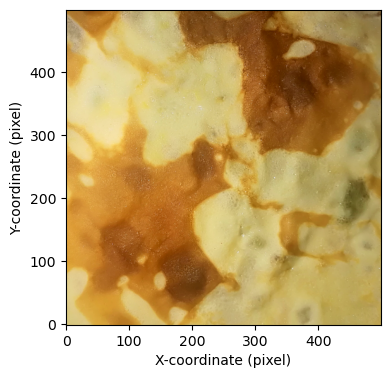

In [23]:
import skgstat as skg
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# get the pancake bands
red = skg.data.pancake_field(band=0).get('sample')
green = skg.data.pancake_field(band=1).get('sample')
blue = skg.data.pancake_field(band=2).get('sample')

rgb = np.stack([red, green, blue], axis=-1)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(rgb, origin='lower')
ax.set_xlabel('X-coordinate (pixel)')
ax.set_ylabel('Y-coordinate (pixel)')
plt.tight_layout()
fig.savefig('./public/img/motivation_pancake_original.png')
fig.show()

In [24]:
# create N random samples across the axes
N = 300
np.random.seed(42)
x = np.random.rand(N) * 500
np.random.seed(43)
y = np.random.rand(N) * 500
coords = np.stack([x, y], axis=-1).astype(int)
# get the values of each band at the coordinates
red_vals = np.array([red[c[0]][c[1]] for c in coords])
blue_vals = np.array([blue[c[0]][c[1]] for c in coords])
green_vals = np.array([green[c[0]][c[1]] for c in coords])

varios = []

for vals in tqdm([red_vals, green_vals, blue_vals]):
    v = skg.Variogram(coords, vals, maxlag=0.6, model='spherical', n_lags=25, use_nugget=True)
    varios.append(v)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 40.19it/s]


/var/folders/jz/t0_43jx90x3btxm6qkgfrnhw0000gn/T/ipykernel_89778/2285530288.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


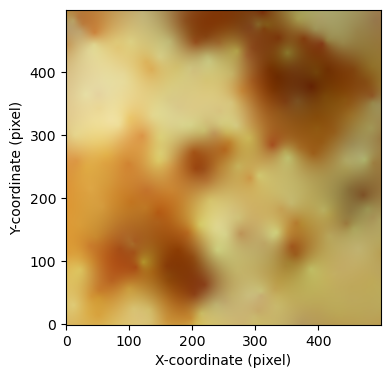

In [7]:
# kriging
krigs = []
sigmas = []

for vario in varios:
    # kriging
    krige = vario.to_gs_krige()
    field, sigma = krige.structured([range(500), range(500)])
    krigs.append(field)
    sigmas.append(sigma)

# plot the kriging result
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.imshow(np.stack(krigs, axis=-1).astype(int), origin='lower')
ax.set_xlabel('X-coordinate (pixel)')
ax.set_ylabel('Y-coordinate (pixel)')
plt.tight_layout()
fig.savefig('./public/img/motivation_pancake_krige.png')
fig.show()

## re-calculate the interpolation with different levels of nugget

In [ ]:
from tqdm import tqdm
from skgstat import OrdinaryKriging

nugs = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
krigs = []

xx, yy = np.mgrid[0:500:5, 0:500:5]

for nug in tqdm(nugs):
    chan_krigs = []
    # interpolate each channel
    for vario in varios:
        old_nug = vario.parameters[-1]
        vario.fit(method='manual', nugget=nug * vario.parameters[1])
                
        # kriging
        krige = vario.to_gs_krige()
        field, sigma = krige.structured([range(0, 500, 5), range(0, 500, 5)])
        chan_krigs.append(field)
        # ok = OrdinaryKriging(vario)
        # k = ok.transform(xx.flatten(), yy.flatten())
        # chan_krigs.append(k.reshape(xx.shape))
        vario.fit(method='manual', nugget=old_nug)

    # stack the channels
    krigs.append(np.stack(chan_krigs, axis=-1).astype(int))

    # plot the kriging result
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    plt.imshow(np.stack(chan_krigs, axis=-1).astype(int), origin='lower')
    ax.set_xlabel('X-coordinate (pixel)')
    ax.set_ylabel('Y-coordinate (pixel)')
    ax.set_title(f'Nugget: {nug * 100}%')
    plt.tight_layout()
    fig.savefig(f'./public/img/motivation_pancake_krige_nugget_{int(nug * 10)}.png')

Add uncertainty to the original pancake

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/jz/t0_43jx90x3btxm6qkgfrnhw0000gn/T/ipykernel_89778/890983341.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


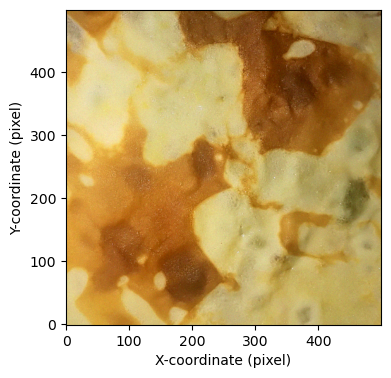

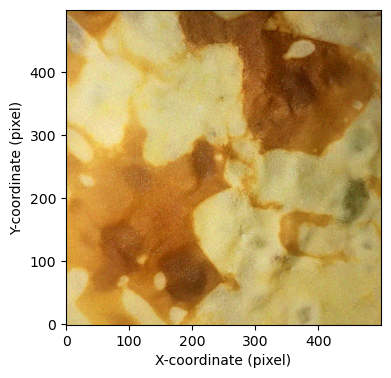

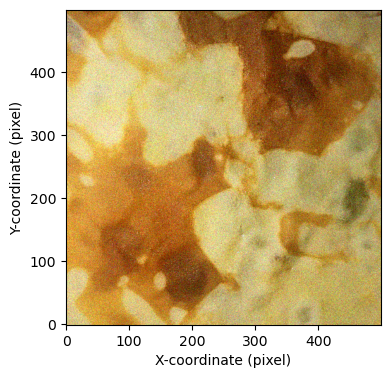

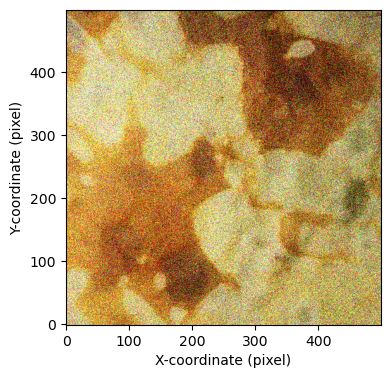

In [25]:
# draw a new sample of the red channel by resampling from a normal distribution of std = 5
SCALE = 10
scales = [5, 10, 20, 50]

for scale in scales:
    np.random.seed(42)
    red2 = np.random.normal(loc=red, scale=scale).astype(int)
    green2 = np.random.normal(loc=green, scale=scale).astype(int)
    blue2 = np.random.normal(loc=blue, scale=scale).astype(int)

    # plot the new sample
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    plt.imshow(np.stack([red2, green2, blue2], axis=-1), origin='lower')
    ax.set_xlabel('X-coordinate (pixel)')
    ax.set_ylabel('Y-coordinate (pixel)')
    plt.tight_layout()

    # check if the current is the main image
    if scale == SCALE:
        fig.savefig('./public/img/motivation_pancake_uncertain.png')
        fig.show()
    
    # always save as step
    fig.savefig(f'./public/img/motivation_pancake_uncertain_{scale}.png')

In [37]:
# estimate variograms with uncertainty intervals
IT = 500
N = 100
np.random.seed(42)
x = np.random.rand(N) * 500
np.random.seed(43)
y = np.random.rand(N) * 500
coords = np.stack([x, y], axis=-1).astype(int)
# get the values of each band at the coordinates
red_vals_u = np.array([red[c[0]][c[1]] for c in coords])
blue_vals_u = np.array([blue[c[0]][c[1]] for c in coords])
green_vals_u = np.array([green[c[0]][c[1]] for c in coords])

# monte carlo simulation for each variogram
varios_u = []
for vals in [red_vals_u, green_vals_u, blue_vals_u]:
    # container for sinlge runs
    emp = np.ones((IT, 25)) * np.nan

    for i in tqdm(range(IT)):
        np.random.seed(i * 138 + 42)
        new_vals = np.random.normal(loc=vals, scale=SCALE)
        new_vario = skg.Variogram(coords, new_vals, maxlag=0.6, model='spherical', n_lags=25, use_nugget=True)
        emp[i] = new_vario.experimental
    
    # get 90% uncertainty bound
    lower = np.quantile(emp, 0.05, axis=0)
    upper = np.quantile(emp, 0.95, axis=0)
    varios_u.append((lower, upper))

100%|██████████| 500/500 [00:02<00:00, 169.10it/s]


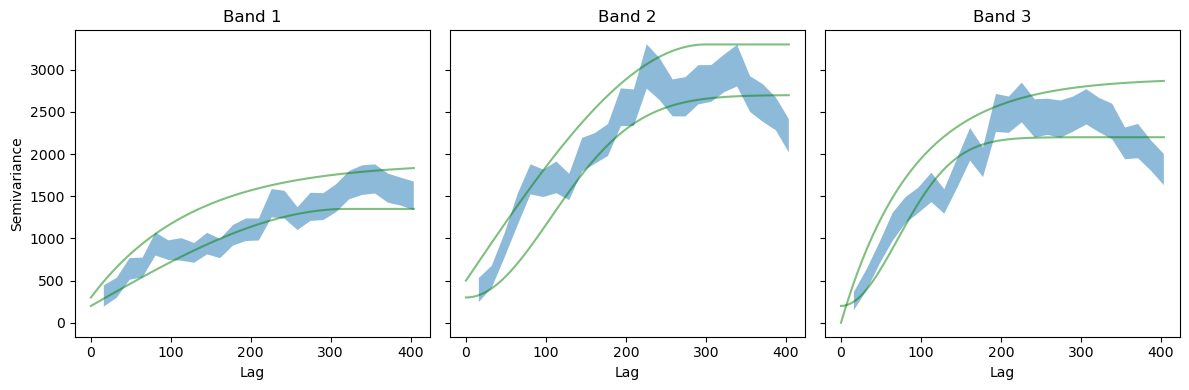

In [39]:
from skgstat import models
# fit some variograms by hand
params = [
    [
        (models.spherical, [320, 1150, 200]),
        (models.exponential, [380, 1600, 300])
    ],
    [
        (models.gaussian, [300, 2400, 300]),
        (models.spherical, [300, 2800, 500])
    ],
    [
        (models.gaussian, [200, 2000, 200]),
        (models.exponential, [270, 2900, 0])
    ]
]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for i, ax in enumerate(axes):
    ax.fill_between(varios[i].bins, varios_u[i][0], varios_u[i][1], alpha=0.5, label='uncertainty')
    
    # plot all variograms
    x = np.linspace(0, varios[i].bins[-1], 100)
    for model, p in params[i]:
        y = model(x, *p)
        ax.plot(x, y, '-g', alpha=0.5)
    
    ax.set_title(f'Band {i + 1}')
    ax.set_xlabel('Lag')
    if i == 0:
        ax.set_ylabel('Semivariance')
plt.tight_layout()
fig.savefig('./public/img/pancake_band_variograms.png')

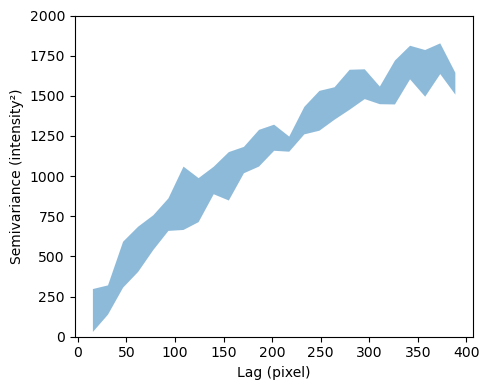

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import skgstat as skg

STEP = 2
# use the first variogram for uncertainty example
coords, vals = skg.data.pancake(N=300, seed=42).get('sample')
vario = skg.Variogram(coords, vals, maxlag=0.6, model='spherical', n_lags=25)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)

if STEP == 0:
    ax.plot(vario.bins, vario.experimental, 'o', label='Experimental Variogram')
else:
    np.random.seed(42)
    ydiff = np.abs(np.random.normal(120, 45, (2, 25)))
    if STEP == 1:
        ax.errorbar(vario.bins, vario.experimental, ydiff, fmt='o', label='Experimental Variogram')
    if STEP == 2:
        ax.fill_between(vario.bins, vario.experimental - ydiff[0], vario.experimental + ydiff[1], alpha=0.5, label='Uncertainty')

ax.set_xlabel('Lag (pixel)')
ax.set_ylabel('Semivariance (intensity²)')
ax.set_ylim(0, 2000)
plt.tight_layout()
fig.savefig(f'public/img/motivation_variogram_step_{STEP}.png')

In [33]:
# kriging

# kriging
krigs_lo = []
sigmas_lo = []
krigs_up = []
sigmas_up = []

for (mod_lo, mod_up), vals in tqdm(zip(params, (red_vals_u, green_vals_u, blue_vals_u))):
    # instantiate the two models
    var_lo = skg.Variogram(coords, vals, maxlag=0.6, model=mod_lo[0].__name__, n_lags=25, use_nugget=True, fit_method='manual', fit_range=mod_lo[1][0], fit_sill=mod_lo[1][1], fit_nugget=mod_lo[1][2])
    var_up = skg.Variogram(coords, vals, maxlag=0.6, model=mod_up[0].__name__, n_lags=25, use_nugget=True, fit_method='manual', fit_range=mod_up[1][0], fit_sill=mod_up[1][1], fit_nugget=mod_up[1][2])

    # kriging
    krige = var_lo.to_gs_krige()
    field_lo, sigma_lo = krige.structured([range(500), range(500)])
    krigs_lo.append(field_lo)
    sigmas_lo.append(sigma_lo)

    krige = var_up.to_gs_krige()
    field_up, sigma_up = krige.structured([range(500), range(500)])
    krigs_up.append(field_up)
    sigmas_up.append(sigma_up)


3it [02:17, 45.69s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


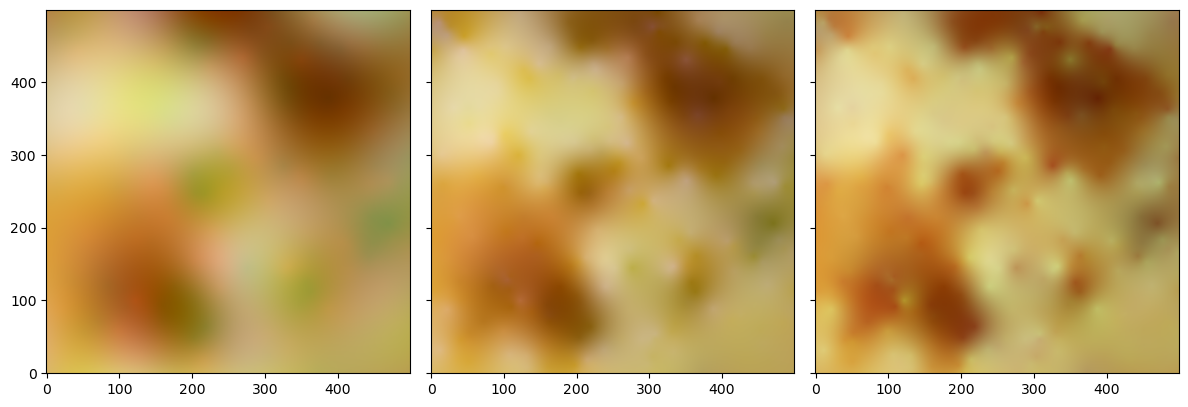

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
axes[0].imshow(np.stack(krigs_lo, axis=-1).astype(int), origin='lower')
axes[1].imshow(np.stack(krigs_up, axis=-1).astype(int), origin='lower')
axes[2].imshow(np.stack(krigs, axis=-1).astype(int), origin='lower')
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


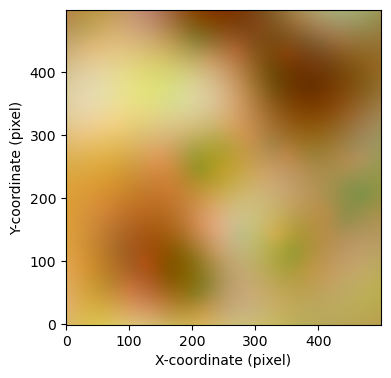

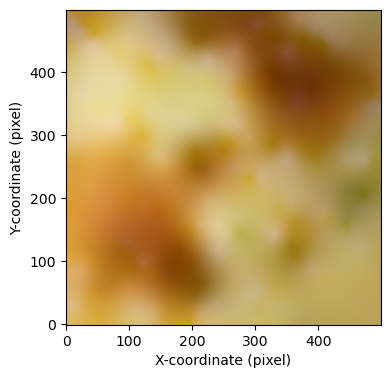

In [34]:
# save each individually

# lo
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.imshow(np.stack(krigs_lo, axis=-1).astype(int), origin='lower')
ax.set_xlabel('X-coordinate (pixel)')
ax.set_ylabel('Y-coordinate (pixel)')
plt.tight_layout()
fig.savefig('./public/img/motivation_pancake_krige_lo.png')

# up
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.imshow(np.stack(krigs_up, axis=-1).astype(int), origin='lower')
ax.set_xlabel('X-coordinate (pixel)')
ax.set_ylabel('Y-coordinate (pixel)')
plt.tight_layout()
fig.savefig('./public/img/motivation_pancake_krige_up.png')

# recreate starzel

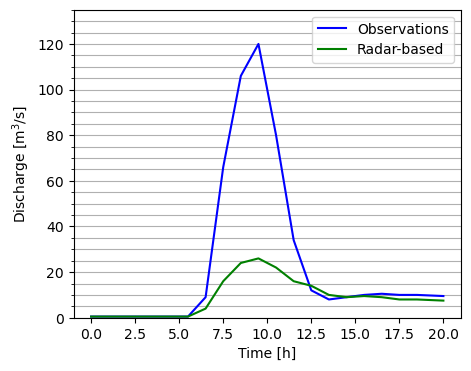

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

STEP = 0

# timestamps
time = [0, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 20]

# different data
obs =   np.array([0.5, 0.5, 9, 66, 106, 120,  80, 34, 12,  8,  9,  10, 10.5, 10, 10, 9.5])
merge = np.array([0.5, 0.5, 9, 70, 124, 128, 100, 60, 39, 24, 16,  10,    9,  8,  8, 7.5])
bora =  np.array([0.5, 0.5, 4, 16,  24,  26,  22, 16, 14, 10,  9, 9.5,    9,  8,  8, 7.5])
gauge = np.array([0.5, 0.5, 8, 40,  86,  94,  76, 52, 36, 24, 18, 10,     9,  8,  8, 7.5])

# plot
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ax.plot(time, obs, 'b-', linewidth=1.5 if STEP == 0 else 1, label='Observations')
ax.plot(time, bora, 'g-', linewidth=1.5 if STEP == 0 else 0.8, label='Radar-based')

if STEP > 0:
    ax.plot([1.5, 15], [28, 28], 'k-', linewidth=2 if STEP == 1 else 1)
    ax.text(2, 30, f'$HQ_{2}$', fontdict={'fontsize': 14 if STEP == 1 else 12})
    ax.plot([1.5, 15], [110, 110], 'k-', linewidth=2 if STEP == 1 else 1)
    ax.text(2, 112, f'$HQ_{{100}}$', fontdict={'fontsize': 14 if STEP == 1 else 12})
if STEP > 1:
    ax.plot(time, gauge, 'k-', linewidth=2 if STEP == 2 else 0.8, label='Gauge-based')
if STEP > 2:
    ax.plot(time, merge, 'r-', linewidth=2 if STEP == 3 else 0.8, label='Gauge+Radar')

# add minor tick marks every two values
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(axis='y', which='both')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Discharge [m$^3$/s]')
ax.set_ylim(0, 135)
ax.legend(loc="upper right")
fig.savefig(f'./public/img/starzel_plot_{STEP}.png')

# Overview 

First the Geostatistical software image

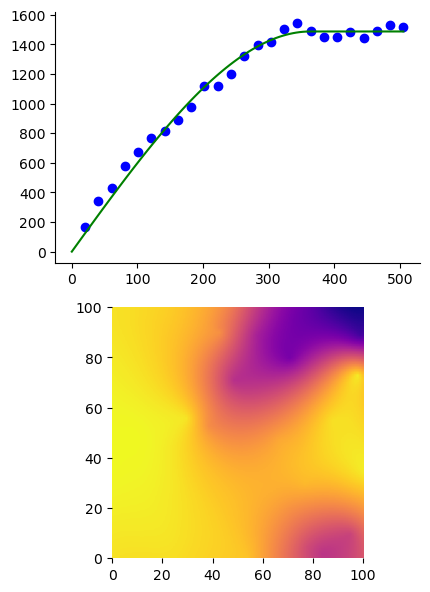

In [3]:
# get the pancake data
coords, vals = skg.data.pancake(N=500).get('sample')
vario = skg.Variogram(coords, vals, normalize=False, maxlag=0.75, n_lags=25)

x = np.linspace(0, vario.bins[-1], 100)
y = vario.fitted_model(x)

krige = vario.to_gs_krige()
field, ss = krige.structured((range(100), range(100)), return_var=True)


fig, axes = plt.subplots(2, 1, figsize=(4.4, 6))
axes[0].plot(vario.bins, vario.experimental, 'bo')
axes[0].plot(x, y, '-g')
axes[1].imshow(field, origin='lower', extent=(0, 100, 0, 100), cmap='plasma')

# remove all spines and axes
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig('public/img/geostatistical_software.png')

Then, an image illustrating the uncertainty package

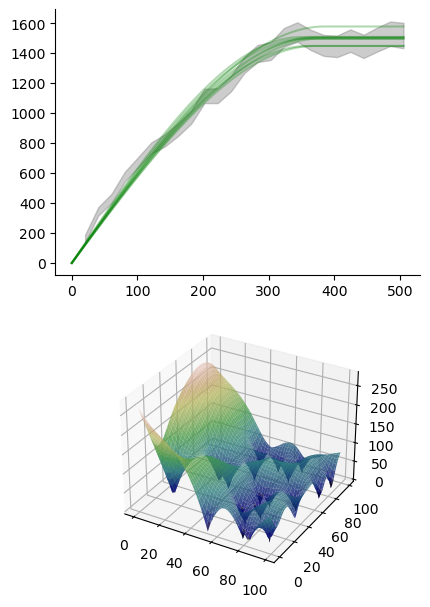

In [4]:
# Make up a random uncertainty band of about 150 units
np.random.seed(42)
lb = vario.experimental - np.random.normal([i *2.5 + 25 for i in range(len(vario.experimental))], scale=0.5)
np.random.seed(44)
ub = vario.experimental + np.random.normal([i *2.5 + 25 for i in range(len(vario.experimental))], scale=0.5)

fig = plt.figure(figsize=(4.4, 6))
ax1 = fig.add_subplot(211)
ax2  = fig.add_subplot(212, projection='3d')

#fig, axes = plt.subplots(2, 1, figsize=(4, 8))
ax1.fill_between(vario.bins, lb, ub, color='gray', alpha=0.4)

# put a few models through the area
x = np.linspace(0, vario.bins[-1], 100)
for r in np.arange(350, 390, 5):
    np.random.seed(r)
    y = skg.models.spherical(x, r, np.random.choice([1450,1490, 1500, 1510, 1550, 1580], 1))
    ax1.plot(x, y, '-g', alpha=0.3)

# create a meshgrid for the field
X, Y = np.meshgrid(range(100), range(100))
ax2.plot_surface(X, Y, ss, cmap='gist_earth', alpha=0.8)

# remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# remove the spines from the 3d plot
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# save
plt.tight_layout()
fig.savefig('public/img/geostatistical_uncertainty.png')

In [9]:
# fit a gaussian, spheircal and exponential model
vario.model = 'gaussian'
y_gaus = vario.fitted_model(x)
p_gaus = vario.parameters

vario.model = 'exponential'
y_exp = vario.fitted_model(x)
p_exp = vario.parameters

vario.model = 'spherical'
y_sph = vario.fitted_model(x)
p_sph = vario.parameters

# print the vario bins and experimental values to a json file
import json
with open('src/slides/data/vario.json', 'w') as f:
    json.dump({
        'bins': vario.bins.round(1).tolist(),
        'experimental': vario.experimental.round(1).tolist(),
        'modelX': x.round(1).tolist(),
        'modelGauss': y_gaus.round(1).tolist(),
        'modelExp': y_exp.round(1).tolist(),
        'modelSph': y_sph.round(1).tolist(),
        'paramsGauss': p_gaus,
        'paramsExp': p_exp,
        'paramsSph': p_sph,
    }, f, indent=4)

# generate pre-defined uncertainty bounds

In [37]:
from collections import defaultdict
import json
from skgstat_uncertainty.processor.propagation import conf_interval_from_sample_std, kfold_residual_bootstrap, mc_absolute_observation_uncertainty

# result dict
data = defaultdict(lambda: {})

# put parameter here
CL = 0.95
N = [30, 50, 100, 300]

# go for each sample size
for n in N:
    # create a new variogram
    coords, vals = skg.data.pancake(N=n, seed=42).get('sample')
    v = skg.Variogram(coords, vals, normalize=False, maxlag=0.6, n_lags=10 if n < 100 else 15)

    data[f"{n}"]['bins'] = v.bins.tolist()

    # std z-score intervals
    intv_z = conf_interval_from_sample_std(v, CL)

    # k-fold
    intv_k = kfold_residual_bootstrap(v, k = 5 if n < 100 else 7, seed=42, q=[int((1 - CL) * 100), int(CL * 100)])

    # mc absolute observation uncertainty
    res = list(mc_absolute_observation_uncertainty(v, sigma=10, iterations=50, seed=42, sigma_type='precision'))[-1]
    intv_mc = np.column_stack((np.nanpercentile(res, (1 - CL) * 100, axis=0), np.nanpercentile(res, CL * 100, axis=0)))

    # add
    data[f"{n}"]['z-score'] = intv_z
    data[f"{n}"]['k-fold'] = intv_k
    data[f"{n}"]['mc'] = intv_mc.tolist()

# write results
with open('src/slides/data/uncertainty.json', 'w') as f:
    json.dump(data, f, indent=4)

# Variogram example

In [ ]:
import skgstat as skg

# create a new variogram
coords, vals = skg.data.pancake(N=300, seed=42).get('sample')
vario = skg.Variogram(coords, vals, normalize=False, maxlag=0.6, n_lags=25, model='spherical')

fig = vario.plot(hist=False, show=False)
fig.savefig('public/img/default_variogram.png')

fig = vario.plot(hist=True, show=False)
fig.savefig('public/img/default_variogram_hist.png')

# Add some models

In [51]:
from skgstat import models

# use N = 100 and method = 'k-fold
bins = data['100']['bins']
intv  = data['100']['k-fold']
x = np.linspace(0, bins[-1], 100)



# plot using plotly
import plotly.graph_objects as go
fig = go.Figure([
    go.Scatter(x=bins, y=[_[0] for _ in intv], mode='lines', showlegend=False, fill='none', line=dict(color='gray', width=0.5)),
    go.Scatter(x=bins, y=[_[1] for _ in intv], mode='lines', showlegend=False, fill='tonexty', line=dict(color='gray', width=0.5)),
])

model = 'gaussian'
model_func = getattr(models, model)
y = model_func(x, 340, 1500, 200)

fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Spherical Model', line=dict(color='green', width=2)))
fig

In [52]:
# read existing data
import json
import os

if os.path.exists('src/slides/data/uncertain_models.json'):
    with open('src/slides/data/uncertain_models.json', 'r') as f:
        sav = json.load(f)
else:
    sav = {'x': x.tolist()}

# add new data
if 'models' in sav:
    sav['models'].append(y.tolist())
else:
    sav['models'] = [y.tolist()]

# save back
with open('src/slides/data/uncertain_models.json', 'w') as f:
    json.dump(sav, f, indent=4)

# image samples

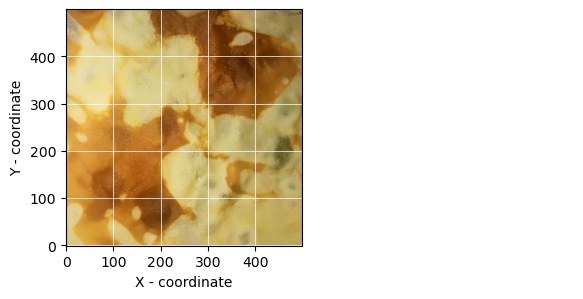

In [6]:
import skgstat as skg
import numpy as np
import matplotlib.pyplot as plt

# get the pancake data
r = skg.data.pancake_field(0).get('sample') 
g = skg.data.pancake_field(1).get('sample')
b = skg.data.pancake_field(2).get('sample')

rgb = np.stack([r, g, b], axis=-1)

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')
ax.imshow(rgb, origin='lower')
ax.grid(True, color='white', linewidth=0.5)
plt.tight_layout()
fig.savefig('public/img/pancake_field_rgb.png')

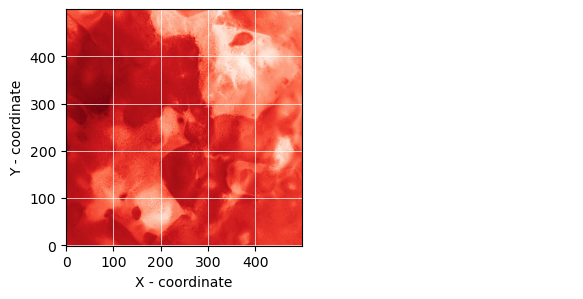

In [7]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')
ax.imshow(r, cmap='Reds', origin='lower')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')
ax.grid(True, color='white', linewidth=0.5)
plt.tight_layout()
fig.savefig('public/img/pancake_field_r.png')

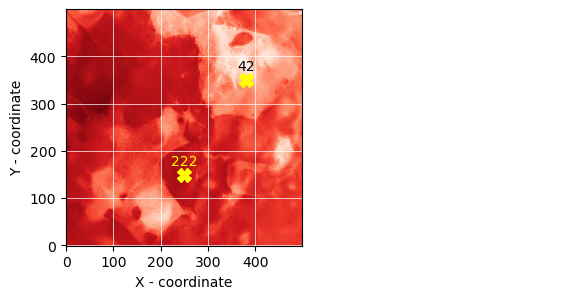

In [8]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')

ax.imshow(r, cmap='Reds', origin='lower')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')

# plot two yellow crosses
ax.plot([250, 380], [150, 350], color='yellow', marker='X', linestyle='None', markersize=10)

# add text labels above the crosses
ax.text(250, 150+28, '222', color='yellow', fontsize=10, ha='center', va='center')
ax.text(380, 350+28, '42', color='black', fontsize=10, ha='center', va='center')

ax.grid(True, color='white', linewidth=0.5)
plt.tight_layout()
fig.savefig('public/img/pancake_field_sample.png')

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from itertools import combinations
import skgstat as skg

# sample size
N = 8 

# get the red channel
r = skg.data.pancake_field(0).get('sample') 

# pre generate the random samples
np.random.seed(42)
xx =  np.random.randint(25, 475, N * 2)
yy =  np.random.randint(25, 475, N * 2)

# make points
points = list(zip(xx, yy))
all_p = list(combinations(points, 2))

# create a GIF of the images
frames = []
all_diffs = []
all_dist = []

#for i,j in zip(range(0, N * 2, 2), range(1, N * 2, 2)):
for i, (p1, p2) in enumerate(all_p):
    # get the two pixel values
    v1 = int(r[p1])
    v2 = int(r[p2])

    # get the differences
    diff = np.abs(v1 - v2)
    all_diffs.append(diff)

    # get the distance
    dist = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    all_dist.append(dist)

    # create a new image for each frame
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # plot the image
    m = ax.imshow(r, cmap='Reds', origin='lower')
    ax.set_xlabel('X - coordinate')
    ax.set_ylabel('Y - coordinate')
    ax.plot(xx, yy, color='gray', alpha=0.8, marker='X', markersize=10, linestyle='None')
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='yellow', marker='X', linestyle='--', lw=0.8, markersize=10)
    
    # add text labels above the crosses
    ax.text(p1[0], p1[1] + 28, v1, color='yellow', fontsize=10, ha='center', va='center')
    ax.text(p2[0], p2[1] + 28, v2, color='yellow', fontsize=10, ha='center', va='center')

    ax.grid(True, color='white', linewidth=0.5)
    
    # create the point cloud
    if i > 0:
        ax2.plot(all_dist[:-1], all_diffs[:-1], color='blue', marker='o', linestyle='None', markersize=5, alpha=0.5)
    ax2.plot(all_dist[-1], all_diffs[-1], color='yellow', marker='o', linestyle='None', markersize=7, alpha=1.0)
    ax2.set_xlabel('Separating distance (pixel)')
    ax2.set_ylabel('Absolute difference (intensity)')
    ax2.set_xlim(0, 450)
    ax2.set_ylim(0, 50)
    plt.tight_layout()
    fig.canvas.draw()

    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(int(height), int(width), 3)
    img = Image.fromarray(img)

    # save the image as a frame of the GIF
    img.save(f'frame_{i+1}.png')
    frames.append(Image.open(f'frame_{i+1}.png'))

    # close
    plt.close()

# save the frames as a GIF
frames[0].save('public/img/pancake_animation.gif', format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0)

# remove the frames_*.png files
for file in glob.glob('frame_*.png'):
    os.remove(file)

In [11]:
# build the separating distance plot on the one side and the animation of the variogram on the other
import skgstat as skg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import lines
import numpy as np
from PIL import Image
import glob
import os

# get the data and build the variogram
coords, vals = skg.data.pancake(N=300).get('sample')
vario = skg.Variogram(coords, vals, normalize=False, n_lags=25, maxlag=0.7)

# calculate some limits
maxy = np.max(vario._diff) * 1.03
maxx = np.max(vario.distance) * 1.01
# create a gif
frames = []
#all_dists, all_diffs = [], []

# go through each lag class
for i, (low, high) in enumerate(zip([0] + vario.bins.tolist()[:-1], vario.bins.tolist())):
    # create the figure for the new image
    fig = plt.figure(figsize=(6, 3))
    ax1 = fig.add_subplot(121)
    ax2_ = fig.add_subplot(122)
    ax2 = ax2_.twinx()

    # plot the difference plot
    ax1.plot(vario.distance, vario._diff, color='blue', marker='o', linestyle='None', markersize=3, alpha=0.5)

    # mark the current lower and higher bound with a box
    ax1.add_patch(patches.Rectangle((low, 0), high - low, maxy, color='red', alpha=0.5, zorder=3))

    # add vertical dashed red lines for all vario.bins, that are smaller than the current low
    for b in vario.bins[vario.bins < low]:
        ax1.axvline(b, color='red', linestyle='--', alpha=0.8, zorder=2)

    # add the all experimental variogram values to ax2, that are smaller than the current low
    ax2.plot(vario.bins[vario.bins < low], vario.experimental[(vario.bins < low)], color='blue', marker='o', linestyle='None', markersize=4)

    # add the current experimental variogram value to ax2 highted
    ax2.plot(vario.bins[vario.bins == high], vario.experimental[(vario.bins == high)], color='red', marker='o', linestyle='None', markersize=5)

    # draw an arrow from ax1 patch to ax2 point
    # define the coordinates in the plots
    xy1 = (low + (high - low) / 2, maxy / 2)
    xy2 = (high, float(vario.experimental[(vario.bins == high)][0]))

    # create figure transforms
    transFigure = fig.transFigure.inverted()
    coord1 = transFigure.transform(ax1.transData.transform(xy1))
    coord2 = transFigure.transform(ax2.transData.transform(xy2))
    line = lines.Line2D((coord1[0], coord2[0]), (coord1[1], coord2[1]), transform=transFigure, color='red', linestyle='--', alpha=0.8, zorder=2)
    fig.lines.append(line)

    # set the limits
    ax1.set_xlim(0, maxx)
    ax1.set_ylim(0, maxy)
    ax2.set_xlim(0, vario.bins.max() * 1.04)
    ax2.set_ylim(0, vario.experimental.max() * 1.02)

    # set axis labels
    ax1.set_xlabel('Separating distance (pixel)')
    ax2_.set_xlabel('Separating distance (pixel)')
    ax1.set_ylabel('Absolute difference (intensity)')
    ax2.set_ylabel('Semi-variance (intensity²)')
    ax2_.yaxis.set_visible(False)
    
    # creat the image
    plt.tight_layout()
    fig.canvas.draw()

    # create an in-memory image
    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(int(height), int(width), 3)
    img = Image.fromarray(img)
    
    # save the image as a frame of the GIF
    img.save(f'frame_{i+1}.png')
    frames.append(Image.open(f'frame_{i+1}.png'))

    # close
    plt.close()

# save the frames as a GIF
frames[0].save('./public/img/lagclasses_animation.gif', format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)

# remove the frames_*.png files
for file in glob.glob('frame_*.png'):
    os.remove(file)
    

# Parallel Coordinates

In [13]:
# imports
from skgstat_uncertainty.api import API
from skgstat_uncertainty.components.plotting import metric_parcats, base_conf_graph, make_subplots

api = API(data_path='/home/mirko/Dropbox/python/uncertain_geostatistics/data', db_name='u_Mirko.db')

pan = api.get_upload_data(id=2)

params = pan.variograms[0]
conf = params.conf_intervals[0]


In [14]:
from plotly.io import write_json

#fig = metric_parcats(conf.models, metrics=['rmse', 'dic', 'cv'], percentiles=[10, 20, 40, 60, 80, 90])
#fig = metric_parcats(conf.models, metrics=['dic', 'rmse', 'cv'], percentiles=[25, 50, 75])
fig = metric_parcats(conf.models, metrics=['dic', 'rmse', 'cv'], percentiles=[10, 20, 30, 40, 50, 60, 70, 80, 90])

with open('src/slides/data/metric_parcat.json', 'w') as f:
    write_json(fig, f, pretty=True)

fig

In [17]:
from skgstat import models
from numpy import linspace
import plotly.graph_objects as go

# generate the x data
x  = linspace(0,  params.variogram.bins[-1], 100)

fig = base_conf_graph(params, conf)

for i, m in enumerate(conf.models):
    name = m.parameters['model_params']['model']
    par = m.parameters['model_params']
    mod_func = getattr(models, name)

    # call
    if name in ('stable', 'matern'):
        y = mod_func(x, par['range'], par['sill'], par['shape'], par['nugget'])
    else:
        y = mod_func(x, par['range'], par['sill'], par['nugget'])

    # add to the figure
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color='green', line_width=1, opacity=0.5, showlegend=i == 0, name='Theoretical models'))

fig.update_layout(
    yaxis=dict(title="Semi-variance (intensity²)"),
    xaxis=dict(title="Separating distance lag (pixel)"),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
# save the figure
with open('src/slides/data/theoretical_models.json', 'w') as f:
    write_json(fig, f, pretty=True)

fig

# Soil Moisture data

In [18]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [19]:
# load the data
store = pd.HDFStore('./dev_data/daily_agg.hd5')
m30 = store.get('m30')
store.close()

positions = pd.read_csv('./dev_data/positions.csv')

In [20]:
# filter out all data where the mean is > 0.5
m30 = m30.loc[:, m30.mean() < 0.4]

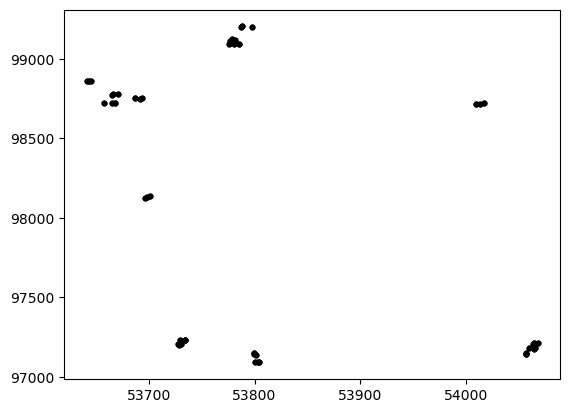

In [7]:
positions2 = positions.where(positions.x < 55000).dropna()
plt.scatter(positions2.x, positions2.y, c='k', cmap='Reds', s=10)

In [21]:
WIDTH = 30

# use only a subset of the data
#sam = m30['20130401':'20140101']
sam = m30['20150101':'20160101']

# get only the positions
pos = positions.set_index('d').loc[:, ('x', 'y')].copy()

# container for results
slices = []

for i in tqdm(range(1, sam.shape[0] - WIDTH)):
    vals = sam.iloc[i:i + WIDTH, :].mean()
    vals.name = 'moisture'

    # merge and save
    df = pd.merge(pos, vals, left_index=True, right_index=True).dropna(how='any', axis='index')
    slices.append(df.copy())

print(f'Generated {len(slices)} slices')

  0%|          | 0/335 [00:00<?, ?it/s]

Generated 335 slices


In [9]:
# build variograms for all
from skgstat import Variogram

# some static parameters
n_lags = 8
maxlag = 'median'
model = 'stable'
bin_func = 'uniform'

pos = positions2.set_index('d').loc[:, ('x', 'y')].copy()

# container for variograms
day_varios = []

for i in tqdm(range(1, sam.shape[0])):
    vals = sam.iloc[i]
    df = pd.merge(pos, vals, left_index=True, right_index=True).dropna(how='any', axis='index')
    vario = Variogram(df[['x', 'y']].values, df.iloc[:, -1].values, n_lags=n_lags, use_nugget=True, maxlag=maxlag, normalize=False, model=model, bin_func=bin_func)
    day_varios.append(vario)

print(f'Generated {len(day_varios)} variograms')

  0%|          | 0/365 [00:00<?, ?it/s]

Generated 365 variograms


In [22]:
# try to come up with something else
# build variograms for all
from skgstat import Variogram

# some static parameters
n_lags = 8
maxlag = 'median'
model = 'stable'
bin_func = 'uniform'

# container for variograms
varios = []

for df in tqdm(slices):
    vario = Variogram(df[['x', 'y']].values, df.moisture.values, n_lags=n_lags, use_nugget=True, maxlag=maxlag, normalize=False, model=model, bin_func=bin_func)
    varios.append(vario)

print(f'Generated {len(varios)} variograms')

  0%|          | 0/335 [00:00<?, ?it/s]

Generated 335 variograms


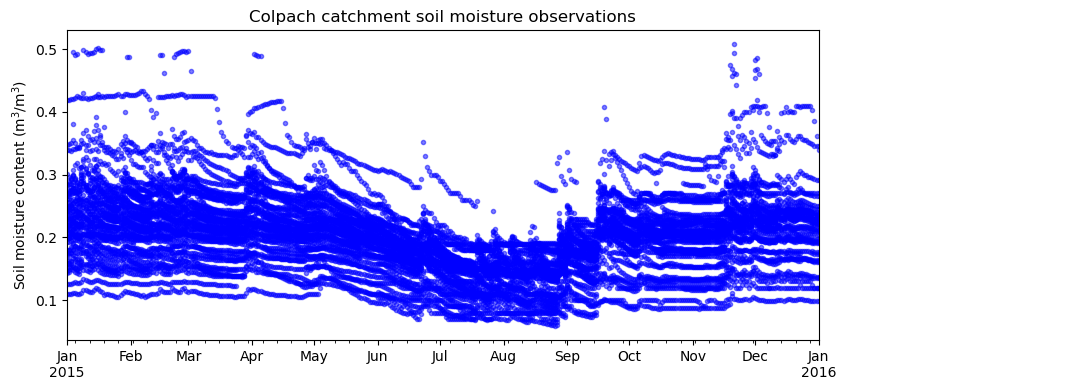

In [71]:
fig = plt.figure(figsize=(11, 4))

# create a grid
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
_a = plt.subplot2grid((1, 4), (0, 3))
_a.axis('off')

# plot the soil moisture
sam.plot(legend=False, c='blue', alpha=0.5, ax=ax1, linestyle='None', marker='o', markersize=3)
ax1.set_ylabel('Soil moisture content (m$^3$/m$^3$)')
ax1.set_title('Colpach catchment soil moisture observations')
plt.tight_layout()

fig.savefig('public/img/motivation_colpach.png')

In [88]:
from PIL import Image
xmin = min([vario.coordinates[:, 0].min() for vario in varios])
xmax = max([vario.coordinates[:, 0].max() for vario in varios])
ymin = min([vario.coordinates[:, 1].min() for vario in varios])
ymax = max([vario.coordinates[:, 1].max() for vario in varios])
vmin = 0.18
vmax = 0.4
x = np.arange(xmin, xmax, 5)
y = np.arange(ymin, ymax, 5)

images = []
n = 130

for i, vario in tqdm(enumerate(day_varios[-n:], start=365 - n), total=n):
    try:
        krige = vario.to_gs_krige()
        field, _ = krige.structured((x, y))
    except ValueError as e:
        continue
    
    if np.isnan(field).all():
        continue

    # open a new figure
    fig = plt.figure(figsize=(11, 4))

    # create a grid
    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((1, 4), (0, 3))

    # plot the soil moisture
    sam.plot(legend=False, c='blue', alpha=0.5, ax=ax1, linestyle='None', marker='o', markersize=3)
    ax1.set_ylabel('Soil moisture content (m$^3$/m$^3$)')

    # set a vertical line to indicate the i position 
    ax1.axvline(sam.index[i], color='red', linestyle='--', linewidth=1.2, alpha=0.9)

    # plot the interpolation
    #ax2.imshow(field.T, extent=[xmin, xmax, ymin, ymax], cmap='gist_earth_r', vmin=vmin, vmax=vmax, origin='lower')
    m = ax2.pcolor(x, y, field.T, cmap='gist_earth_r', vmin=vmin, vmax=vmax)
    
    #ax2.scatter(vario.coordinates[:, 0], vario.coordinates[:, 1], c='red', s=5, alpha=0.5)
    ax2.scatter(positions.x, positions.y, c='red', s=6)
    
    plt.colorbar(m, ax=ax2)
    ax2.set_xlabel('Easting (m)')
    ax2.set_ylabel('Northing (m)')

    ax1.set_title('Colpach catchment soil moisture observations')
    ax2.set_title('Interpolation')
    plt.tight_layout()

    # save the figure as an image
    if True:
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(Image.fromarray(image))
        plt.close()

# save the images as a GIF
images[0].save('public/img/motivation_kriging.gif', save_all=True, append_images=images[1:], duration=100, loop=0)

  0%|          | 0/130 [00:00<?, ?it/s]

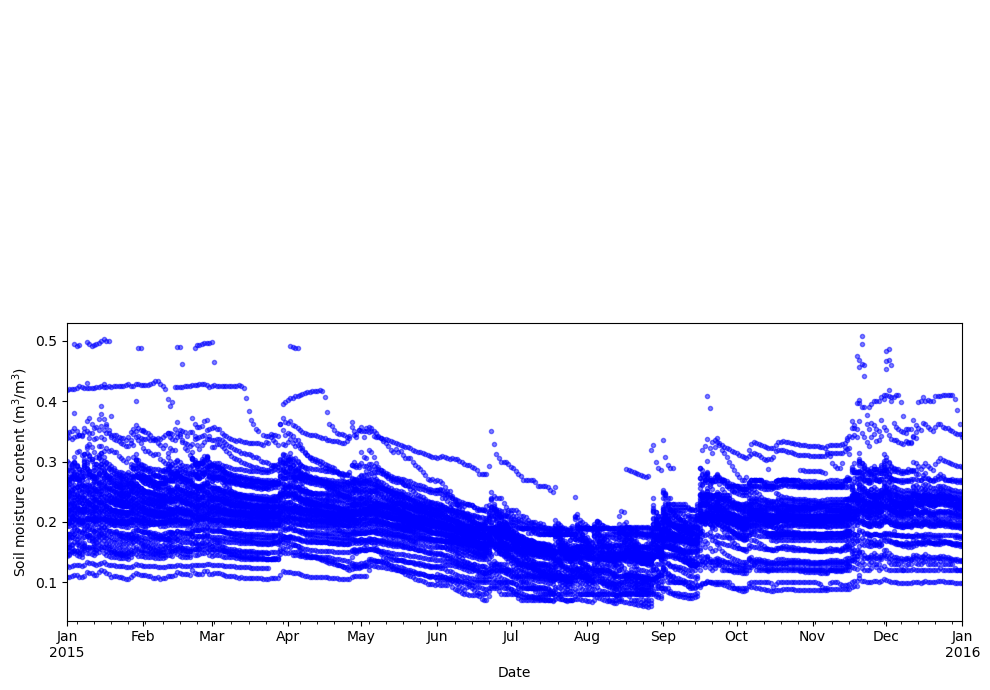

In [24]:
# STEP 1
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))

# create a grid with two rows and two columns
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

# plot on the top left subplot
ax1.axis('off')

# plot on the top right subplot
ax2.axis('off')

# plot on the bottom subplot
sam.plot(legend=False, c='blue', alpha=0.5, ax=ax3, linestyle='None', marker='o', markersize=3)
ax3.set_ylabel('Soil moisture content (m$^3$/m$^3$)')
ax3.set_xlabel('Date')
plt.tight_layout()

fig.savefig('public/img/moisture_cluster_step1.png')

In [25]:
# STEP 2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

images = []

for i, vario in tqdm(enumerate(varios), total=len(varios)):
    fig = plt.figure(figsize=(10, 7))

    # create a grid with two rows and two columns
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    # plot on the top left subplot
    #ax1.axis('off')
    # resolve to 100 values
    for v in varios[:i]:
        x = np.linspace(0, v.bins[-1], 100)
        y = v.fitted_model(x)
        ax1.plot(x, y, '-g', alpha=0.1)
    x = np.linspace(0, vario.bins[-1], 100)
    y = vario.fitted_model(x)
    ax1.plot(x, y, '-g')
    ax1.set_ylabel('Semi-variance')

    # plot on the top right subplot
    ax2.axis('off')

    # plot on the bottom subplot
    sam.plot(legend=False, c='blue', alpha=0.5, ax=ax3, linestyle='None', marker='o', markersize=3)
    ax3.set_ylabel('Soil moisture content (m$^3$/m$^3$)')
    ax3.set_xlabel('Date')

    # add an orange box to ax3
    rect = patches.Rectangle((
        mdates.date2num(sam.index[i].to_pydatetime()), 
        ax3.get_ylim()[0]), 
        WIDTH, 
        ax3.get_ylim()[1] - ax3.get_ylim()[0], 
        linewidth=3, 
        edgecolor=(1, 0.5, 0, 1), 
        facecolor=(1, 0.5, 0, 0.3)
    )
    ax3.add_patch(rect)

    plt.tight_layout()

    # save the figure as an image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(Image.fromarray(image))
    plt.close()

    #if i > 20:
    #    break

# save the images as a GIF
images[0].save('public/img/moisture_cluster_step2.gif', save_all=True, append_images=images[1:], duration=100, loop=0)
#images[0].save('animation.gif', save_all=True, append_images=images[1:], duration=100, loop=0)

  0%|          | 0/335 [00:00<?, ?it/s]

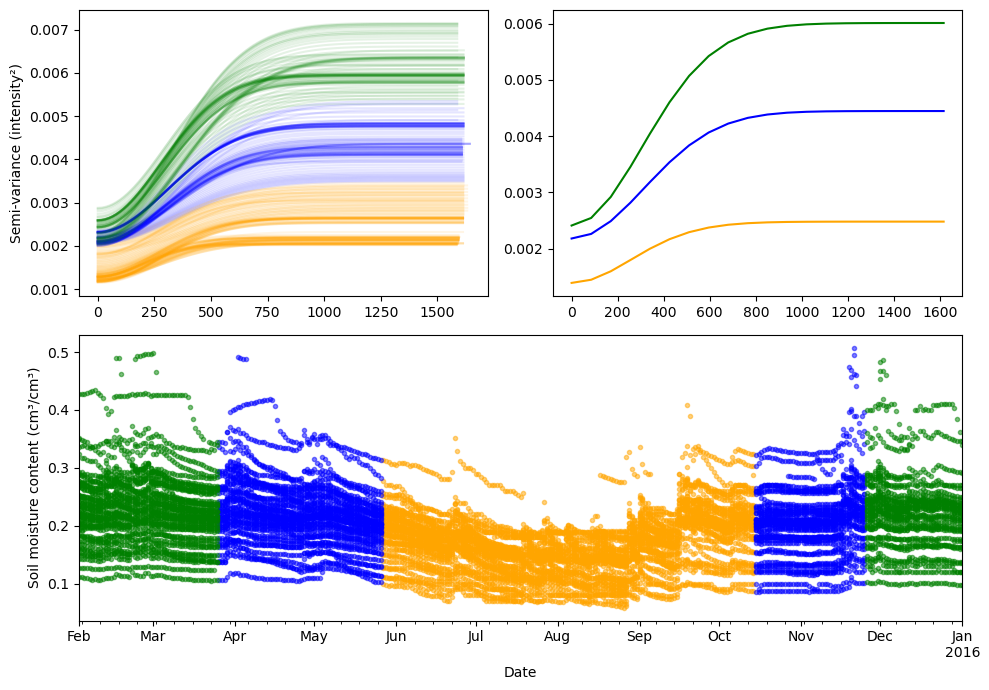

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MeanShift, KMeans
from skgstat.models import stable

# do the clustering
X = np.linspace(0, varios[0].bins[-1], 20)
#data = np.column_stack([np.array(v.parameters) for v in varios])
#data = np.column_stack([np.array(v.experimental) for v in varios])
data = np.column_stack([np.array(v.fitted_model(X)) for v in varios])

#ms = MeanShift(bandwidth=0.0045, min_bin_freq=120)
ms = MeanShift(bandwidth=0.003, min_bin_freq=10)
#ms = KMeans(n_clusters=3)
ms.fit_predict(data.T)

# get all unique labels and add a color for each to a lookup dict
lookup = {0: 'orange', 1: 'blue', 2: 'green', 3: 'red'}

# build the figure
fig = plt.figure(figsize=(10, 7))

# create a grid with two rows and two columns
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

# plot on the top left subplot
#ax1.axis('off')
# resolve to 100 values
for v, lab in zip(varios, ms.labels_):
    x = np.linspace(0, v.bins[-1], 100)
    y = v.fitted_model(x)
    ax1.plot(x, y, alpha=0.1, c=lookup.get(lab, 'gray'))
    #ax1.plot(v.bins, v.experimental, c=lookup.get(lab, 'gray'), alpha=0.1)
ax1.set_ylabel('Semi-variance (intensity²)')

# plot on the top right subplot
for i, pars in enumerate(ms.cluster_centers_):
    #x = np.linspace(0, varios[0].bins[-1], 100)
    #y = stable(x, *pars)
    ax2.plot(X, pars, c=lookup.get(i, 'gray'))


# plot on the bottom subplot
for lab in np.unique(ms.labels_):
    mask = ms.labels_ == lab
    sam[WIDTH + 1:].iloc[mask, :].plot(legend=False, c=lookup.get(lab, 'gray'), alpha=0.5, ax=ax3, linestyle='none', marker='o', markersize=3)
ax3.set_ylabel('Soil moisture content (cm³/cm³)')
ax3.set_xlabel('Date')
#sam.plot(legend=False, c='blue', alpha=0.5, ax=ax3)


plt.tight_layout()
fig.savefig('public/img/moisture_cluster_step3.png')

In [145]:
# arange the data for the clusters
df_arange = sam.iloc[31:, ]

# yellow
df_y = pd.merge(positions[['d', 'x', 'y']].set_index('d'), pd.DataFrame(df_arange.iloc[np.where(ms.labels_==0)[0], :].mean()), left_index=True, right_index=True, how='inner').dropna(how='any')
df_b = pd.merge(positions[['d', 'x', 'y']].set_index('d'), pd.DataFrame(df_arange.iloc[np.where(ms.labels_==1)[0], :].mean()), left_index=True, right_index=True, how='inner').dropna(how='any')
df_g = pd.merge(positions[['d', 'x', 'y']].set_index('d'), pd.DataFrame(df_arange.iloc[np.where(ms.labels_==2)[0], :].mean()), left_index=True, right_index=True, how='inner').dropna(how='any')
df_all = pd.merge(positions[['d', 'x', 'y']].set_index('d'), pd.DataFrame(df_arange.mean()), left_index=True, right_index=True, how='inner').dropna(how='any')

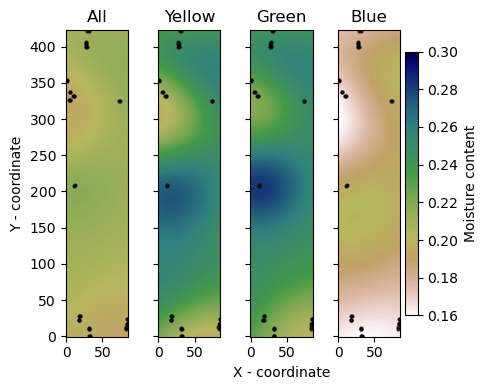

In [172]:
par_y = Variogram(
    df_y[['x', 'y']].values, df_y.iloc[:, -1].values, n_lags=n_lags, use_nugget=True, maxlag=maxlag, normalize=False, model=model, bin_func=bin_func, fit_func=None,
    fit_method='manual', fit_range=700, fit_sill=0.00516196, fit_nugget=0.0024606
)

par_b = Variogram(
    df_b[['x', 'y']].values, df_b.iloc[:, -1].values, n_lags=n_lags, use_nugget=True, maxlag=maxlag, normalize=False, model=model, bin_func=bin_func, fit_func=None,
    fit_method='manual', fit_range=950, fit_sill=0.00730833, fit_nugget=0.0022751
)

par_g = Variogram(
    df_g[['x', 'y']].values, df_g.iloc[:, -1].values, n_lags=n_lags, use_nugget=True, maxlag=maxlag, normalize=False, model=model, bin_func=bin_func, fit_func=None,
    fit_method='manual', fit_range=600, fit_sill=0.0028749, fit_nugget=0.0015893
)

# grid settings
#grid = (np.linspace(df.x.min(), df.x.max(), 100), np.linspace(df.y.min(), df.y.max(), 100))
grid = (np.arange(df.x.min(), df.x.max(), 5), np.arange(df.y.min(), df.y.max(), 5))

# color scale
vmin = 0.16; vmax = 0.30

fig, _a = plt.subplots(1, 4, figsize=(5, 4), sharex=True, sharey=True)
axes = _a.flatten()

# all data
par_all = Variogram(df_all[['x', 'y']].values, df_all.iloc[:, -1].values, n_lags=n_lags, use_nugget=True, maxlag=maxlag, normalize=False, model=model, bin_func=bin_func)

krige = par_all.to_gs_krige()
field, ss = krige.structured(grid, return_var=True)

m = axes[0].imshow(field.T, origin='lower', cmap='gist_earth_r', vmin=vmin, vmax=vmax)
axes[0].scatter(
    ((df_all.x.T - df_all.x.T.min()) / (df_all.x.T.max() - df_all.x.T.min())) * ((np.max(grid[0]) - np.min(grid[0])) / 5),
    ((df_all.y.T - df_all.y.T.min()) / (df_all.y.T.max() - df_all.y.T.min())) * ((np.max(grid[1]) - np.min(grid[1])) / 5),
    c='k', s=4, alpha=0.7)
axes[0].set_title('All')
#plt.colorbar(m, ax=axes[0])

for ax, mod, title in zip(axes[1:], (par_y, par_g, par_b), ('Yellow', 'Green', 'Blue')):
    krige = mod.to_gs_krige()
    field, ss = krige.structured(grid, return_var=True)

    m = ax.imshow(field.T, origin='lower', cmap='gist_earth_r', vmin=vmin, vmax=vmax)
    ax.scatter(
        ((df.x.T - df.x.T.min()) / (df.x.T.max() - df.x.T.min())) * ((np.max(grid[0]) - np.min(grid[0])) / 5), 
        ((df.y.T - df.y.T.min()) / (df.y.T.max() - df.y.T.min())) * ((np.max(grid[1]) - np.min(grid[1])) / 5), 
        c='k', s=4, alpha=0.7)
    ax.set_title(title)

axes[0].set_ylabel('Y - coordinate')
axes[2].set_xlabel('X - coordinate')
cbar = plt.colorbar(m, ax=ax)
cbar.set_label('Moisture content')
plt.tight_layout()
fig.savefig('public/img/moisture_cluster_kriging.png')

# Cluster graphs

In [ ]:
import json

CLUSTER = 'g'

# load
with open(f'./dev_data/vario_graph_{CLUSTER}.json') as f:
    data = json.load(f)

print(f"Loaded {len(data['nodes'])} nodes and {len(data['links'])} links.")

Loaded 54 nodes and 502 links.


In [2]:
# rename all distance values to 'separating' and calculate min and max along the way
minD = 99999
maxD = -1
minR = 99999
maxR = -1

for link in data['links']:
    val = link['distance']
    res = link['residual']

    link['separating'] = val
    if minD > val:
        minD = val
    if maxD < val:
        maxD = val
    if minR > res:
        minR = res
    if maxR < res:
        maxR = res

# in a second loop normalize the separating and residual values to a range of 5 to 100
for link in data['links']:
    link['separating_norm'] = 5 + (link['separating'] - minD) / (maxD - minD) * 95
    link['residual_norm'] = 5 + (link['residual'] - minR) / (maxR - minR) * 95

    # and finally set residual as distance
    link['distance'] = link['residual_norm']

# save
with open(f'./src/slides/data/cluster_{CLUSTER}.json', 'w') as f:
    json.dump(data, f, indent=4)

Create the sample matrices for the benchmark graphs

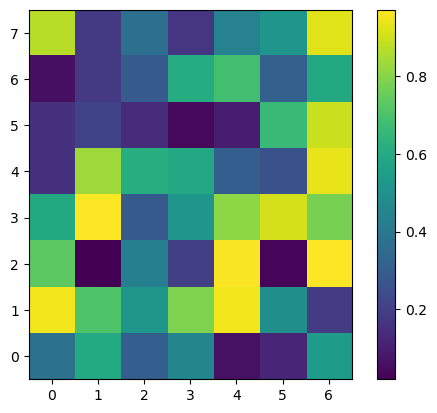

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# random field
np.random.seed(42)
random = np.random.rand(7, 8)

plt.imshow(random.T, origin='lower')
#plt.grid(True, color='white', linewidth=0.5)
plt.colorbar()
plt.gcf().savefig('public/img/benchmark_example_1.png')

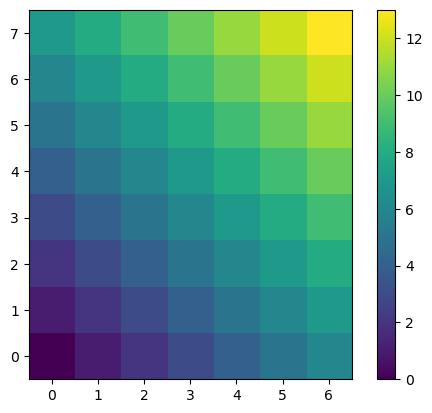

In [2]:
meshs = np.sum(np.meshgrid(range(7), range(8)), axis=0)
plt.imshow(meshs, origin='lower')
#plt.grid(True, color='white', linewidth=0.5)
plt.colorbar()
plt.gcf().savefig('public/img/benchmark_example_2.png')

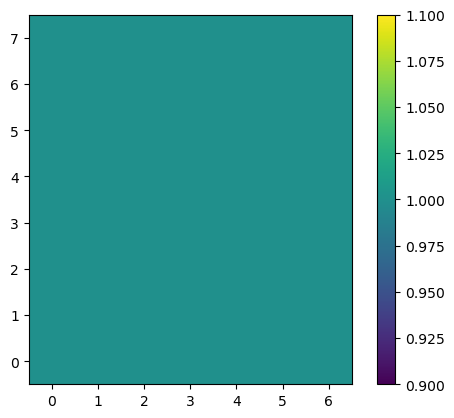

In [3]:
ones = np.ones((7, 8))

plt.imshow(ones.T.astype(int), origin='lower')
#plt.grid(True, color='white', linewidth=0.5)
plt.colorbar()
plt.gcf().savefig('public/img/benchmark_example_3.png')